In [1]:
import numpy as np
import matplotlib.pyplot as plt
from reconstruct import DiscreteWindowedRampFilter
from shepp_logan import shepp_logan
from project import acquire_projections

In [2]:
n_pixels = 1001
n_projections = 1200
tau = 0.1

phantom = shepp_logan(n_pixels)
sinogram = acquire_projections(phantom, n_projections=n_projections)


Text(0.5, 1.0, 'Projection at Theta=0º')

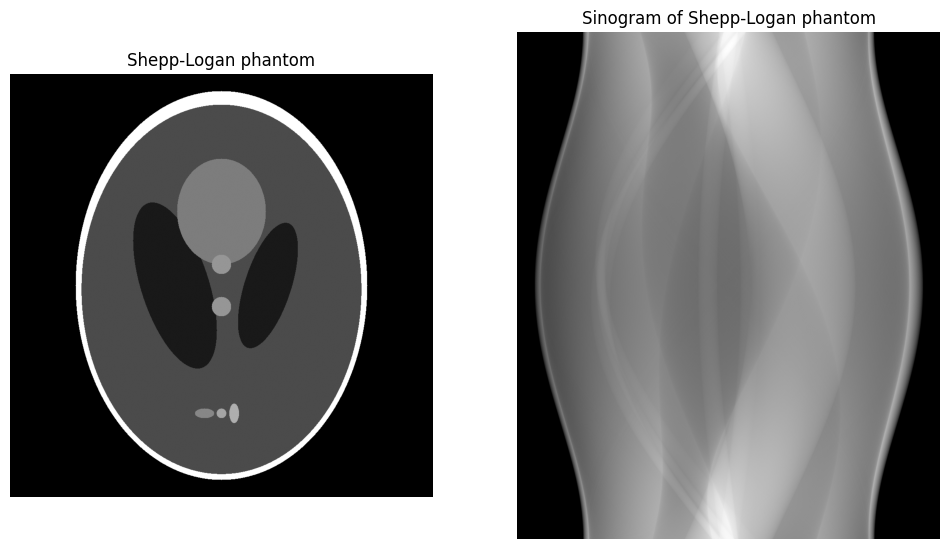

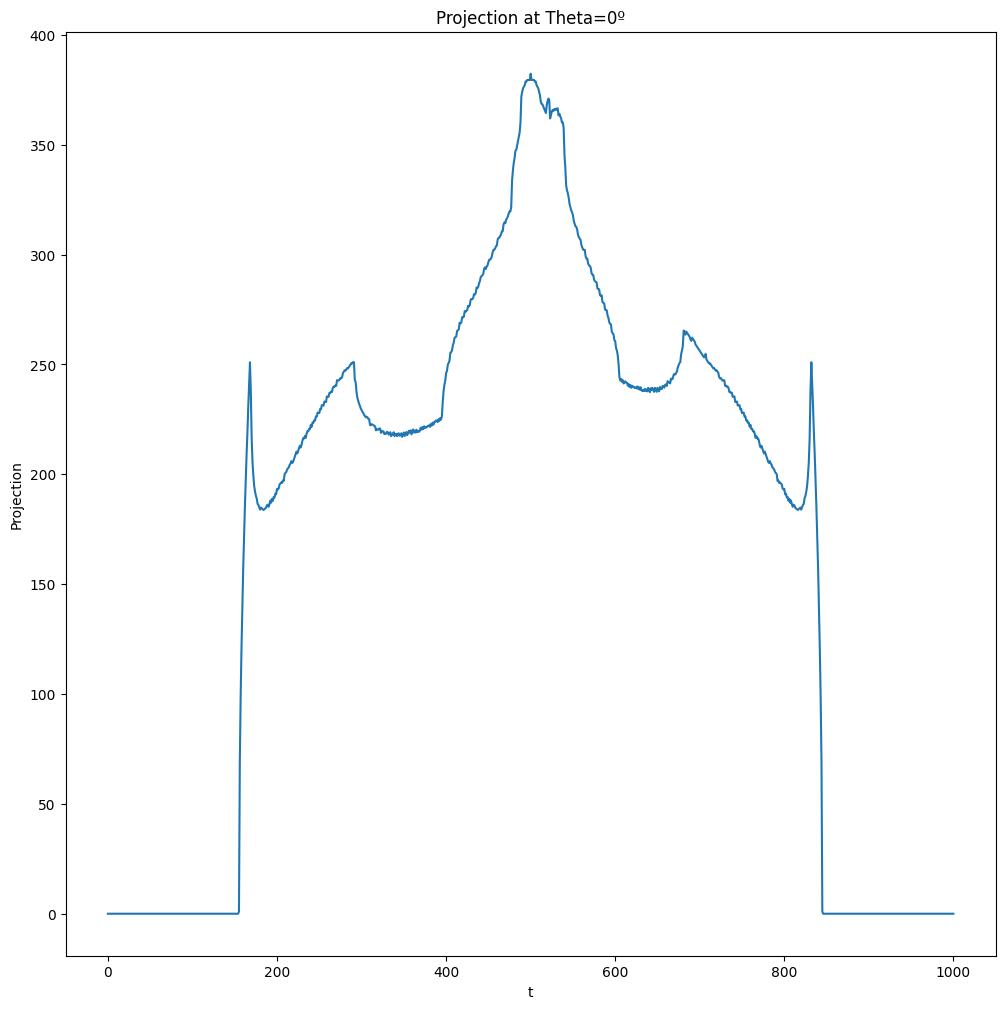

In [3]:
fig, axs = plt.subplots(1,2, figsize=(12, 24))

axs[0].imshow(phantom, cmap="gray")
axs[0].set_title("Shepp-Logan phantom")
axs[0].axis("off")

axs[1].imshow(sinogram, cmap="gray")
axs[1].set_title("Sinogram of Shepp-Logan phantom")
axs[1].axis("off")

fig, ax = plt.subplots(1,1, figsize=(12, 12))
ax.plot(sinogram[0])
ax.set_xlabel("t")
ax.set_ylabel("Projection")

ax.set_title("Projection at Theta=0º")

c:\Users\altp\CT_recon\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\altp\CT_recon\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, '$t$')

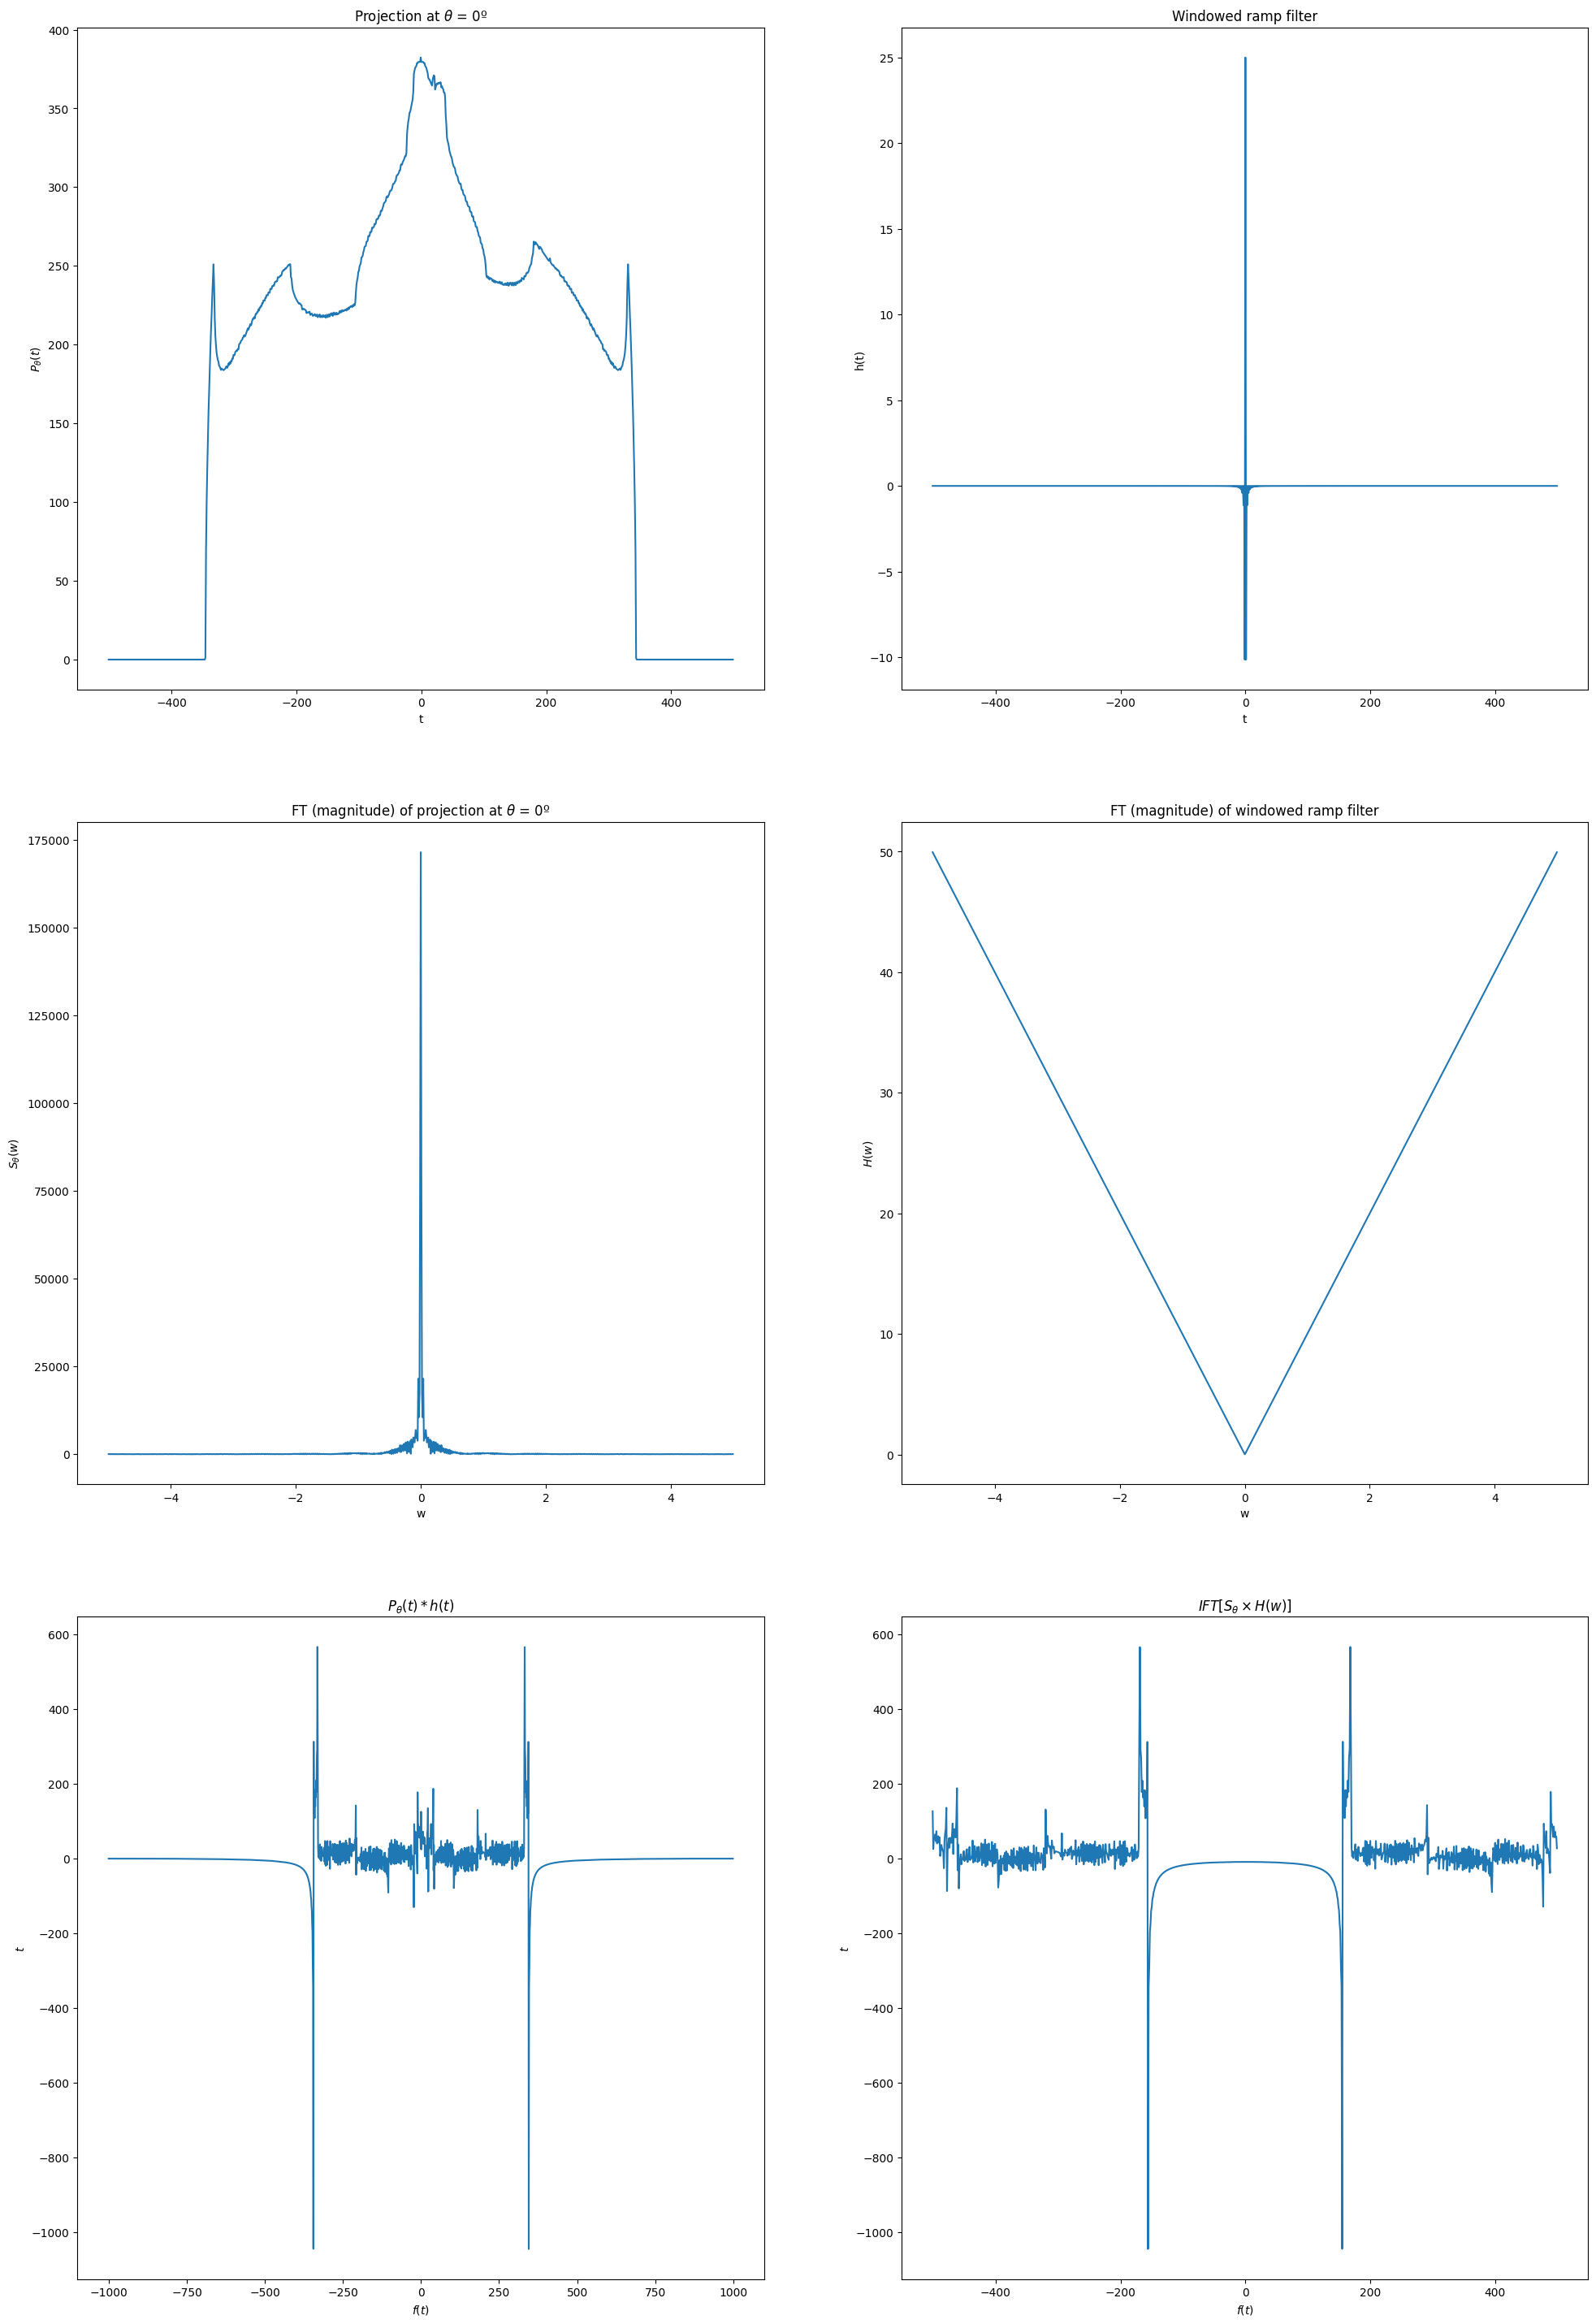

In [4]:
t = np.arange(-n_pixels // 2, n_pixels // 2)

filter = DiscreteWindowedRampFilter(tau)
h_t = filter(t)

P_0 = sinogram[0]

S_0 = np.fft.fftshift(np.fft.fft(P_0))
H_w = np.fft.fftshift(np.fft.fft(h_t))

w = np.fft.fftshift(np.fft.fftfreq(1001, d=tau))

convolution = np.convolve(P_0, h_t)
t_conv = np.arange(-len(convolution) // 2, len(convolution) // 2)

multiplication = np.fft.ifft(np.fft.ifftshift(S_0 * H_w))

fig, axs = plt.subplots(3, 2, figsize=(24, 36))

axs[0,0].plot(t, P_0)
axs[0,0].set_title("Projection at $\\theta$ = 0º")
axs[0,0].set_xlabel("t")
axs[0,0].set_ylabel("$P_\\theta (t)$")

axs[0,1].plot(t, h_t)
axs[0,1].set_title("Windowed ramp filter")
axs[0,1].set_xlabel("t")
axs[0,1].set_ylabel("h(t)")

axs[1,0].plot(w, np.abs(S_0))
axs[1,0].set_title("FT (magnitude) of projection at $\\theta$ = 0º")
axs[1,0].set_xlabel("w")
axs[1,0].set_ylabel("$S_{\\theta}(w)$")

axs[1,1].plot(w, np.abs(H_w))
axs[1,1].set_title("FT (magnitude) of windowed ramp filter")
axs[1,1].set_xlabel("w")
axs[1,1].set_ylabel("$H(w)$")

axs[2,0].plot(t_conv, convolution)
axs[2,0].set_title("$P_\\theta (t) * h(t)$")
axs[2,0].set_xlabel("$f(t)$")
axs[2,0].set_ylabel("$t$")

axs[2,1].plot(t, multiplication)
axs[2,1].set_title("$IFT[S_{\\theta} \\times H(w)]$")
axs[2,1].set_xlabel("$f(t)$")
axs[2,1].set_ylabel("$t$")



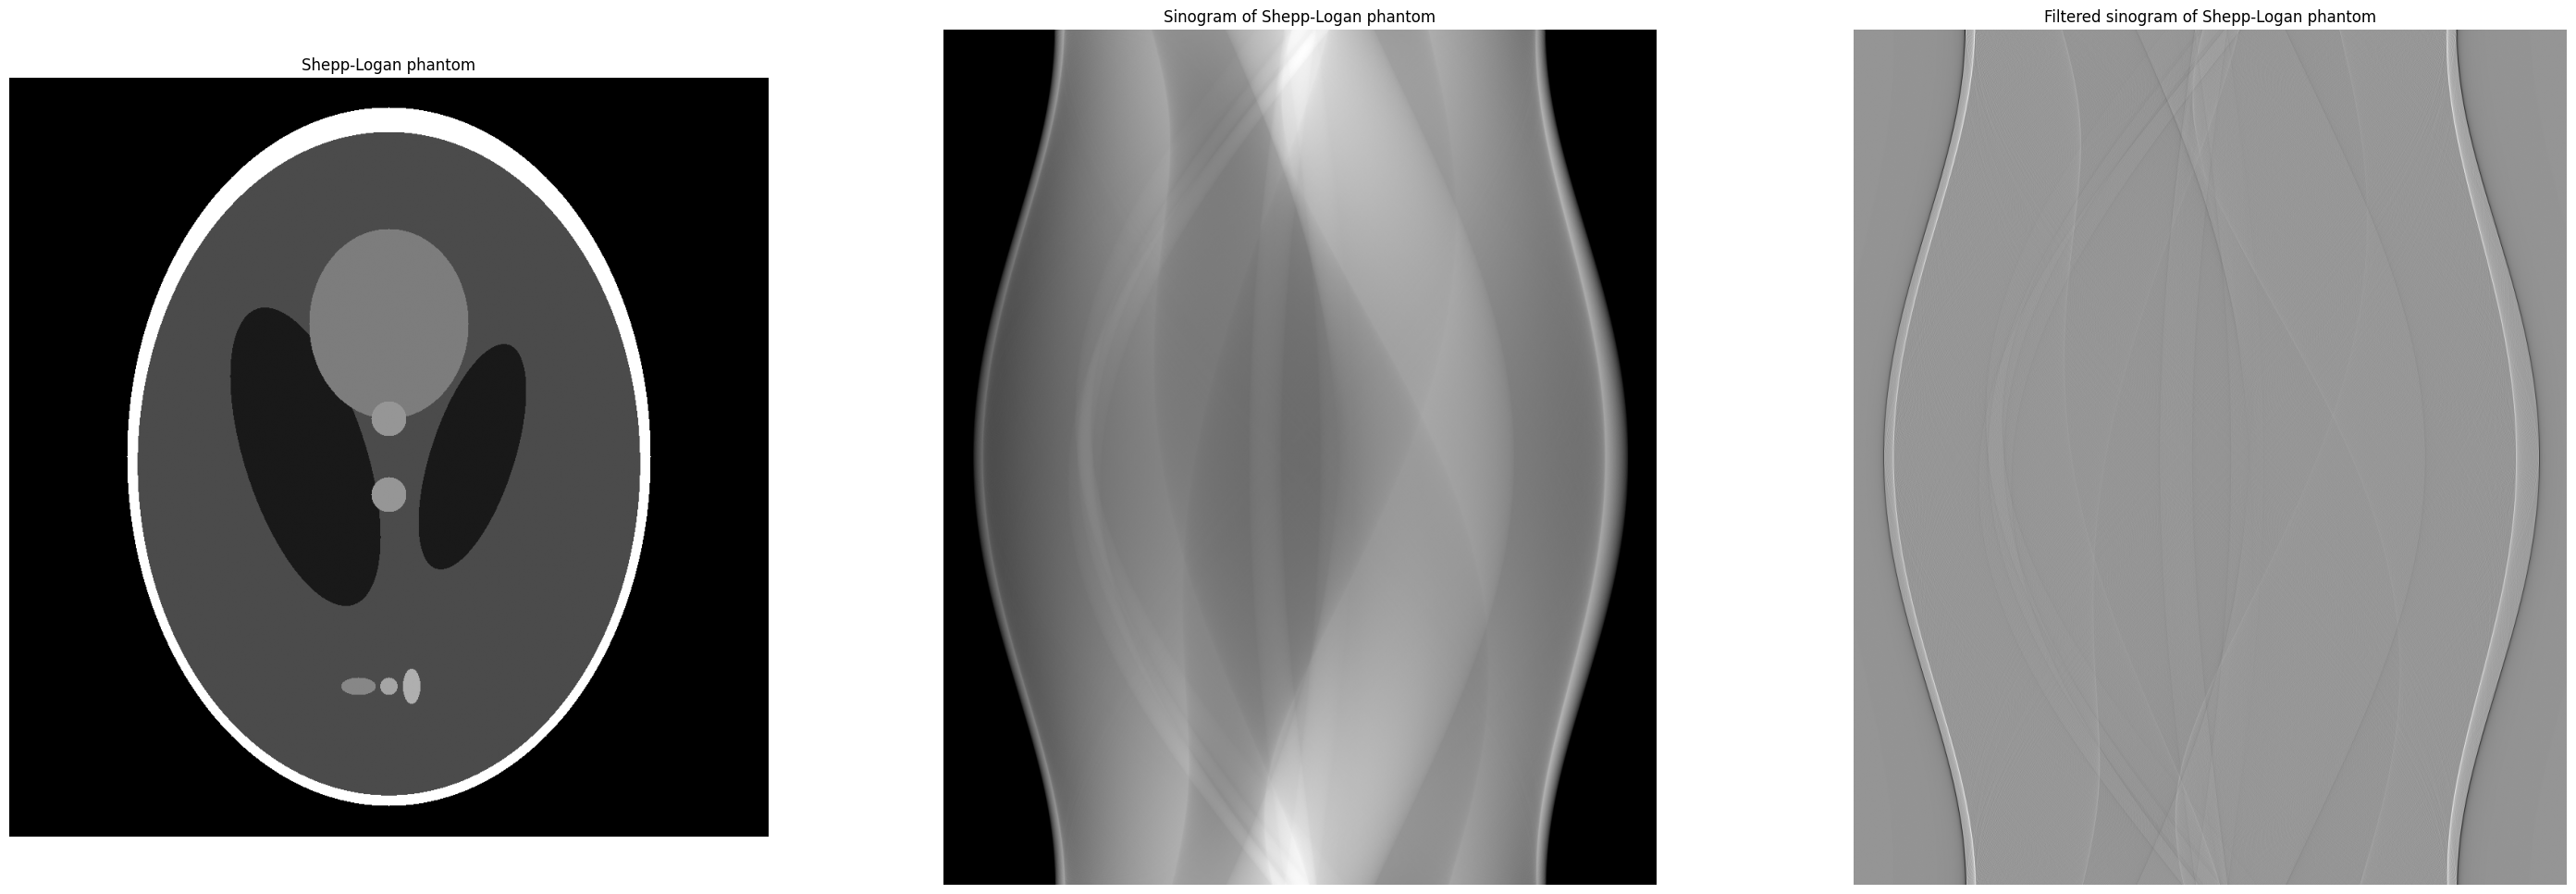

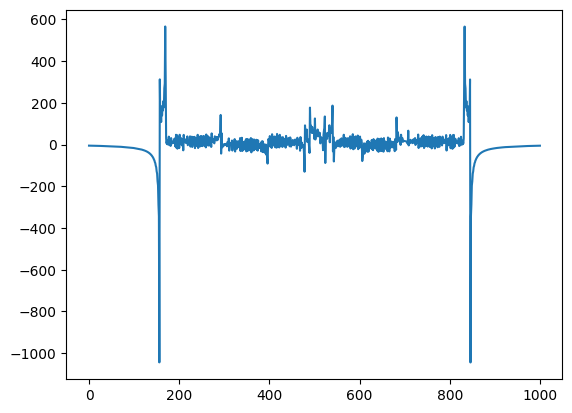

In [5]:
from scipy import signal

fig, axs = plt.subplots(1,3, figsize=(36, 12))

axs[0].imshow(phantom, cmap="gray")
axs[0].set_title("Shepp-Logan phantom")
axs[0].axis("off")

axs[1].imshow(sinogram, cmap="gray")
axs[1].set_title("Sinogram of Shepp-Logan phantom")
axs[1].axis("off")

filtered_sinogram = signal.convolve(sinogram, h_t.reshape(1, -1), mode="same", method="auto")
axs[2].imshow(filtered_sinogram, cmap="gray")
axs[2].set_title("Filtered sinogram of Shepp-Logan phantom")
axs[2].axis("off")

plt.show()

plt.plot(filtered_sinogram[0])

(np.float64(-0.5), np.float64(1000.5), np.float64(1199.5), np.float64(-0.5))

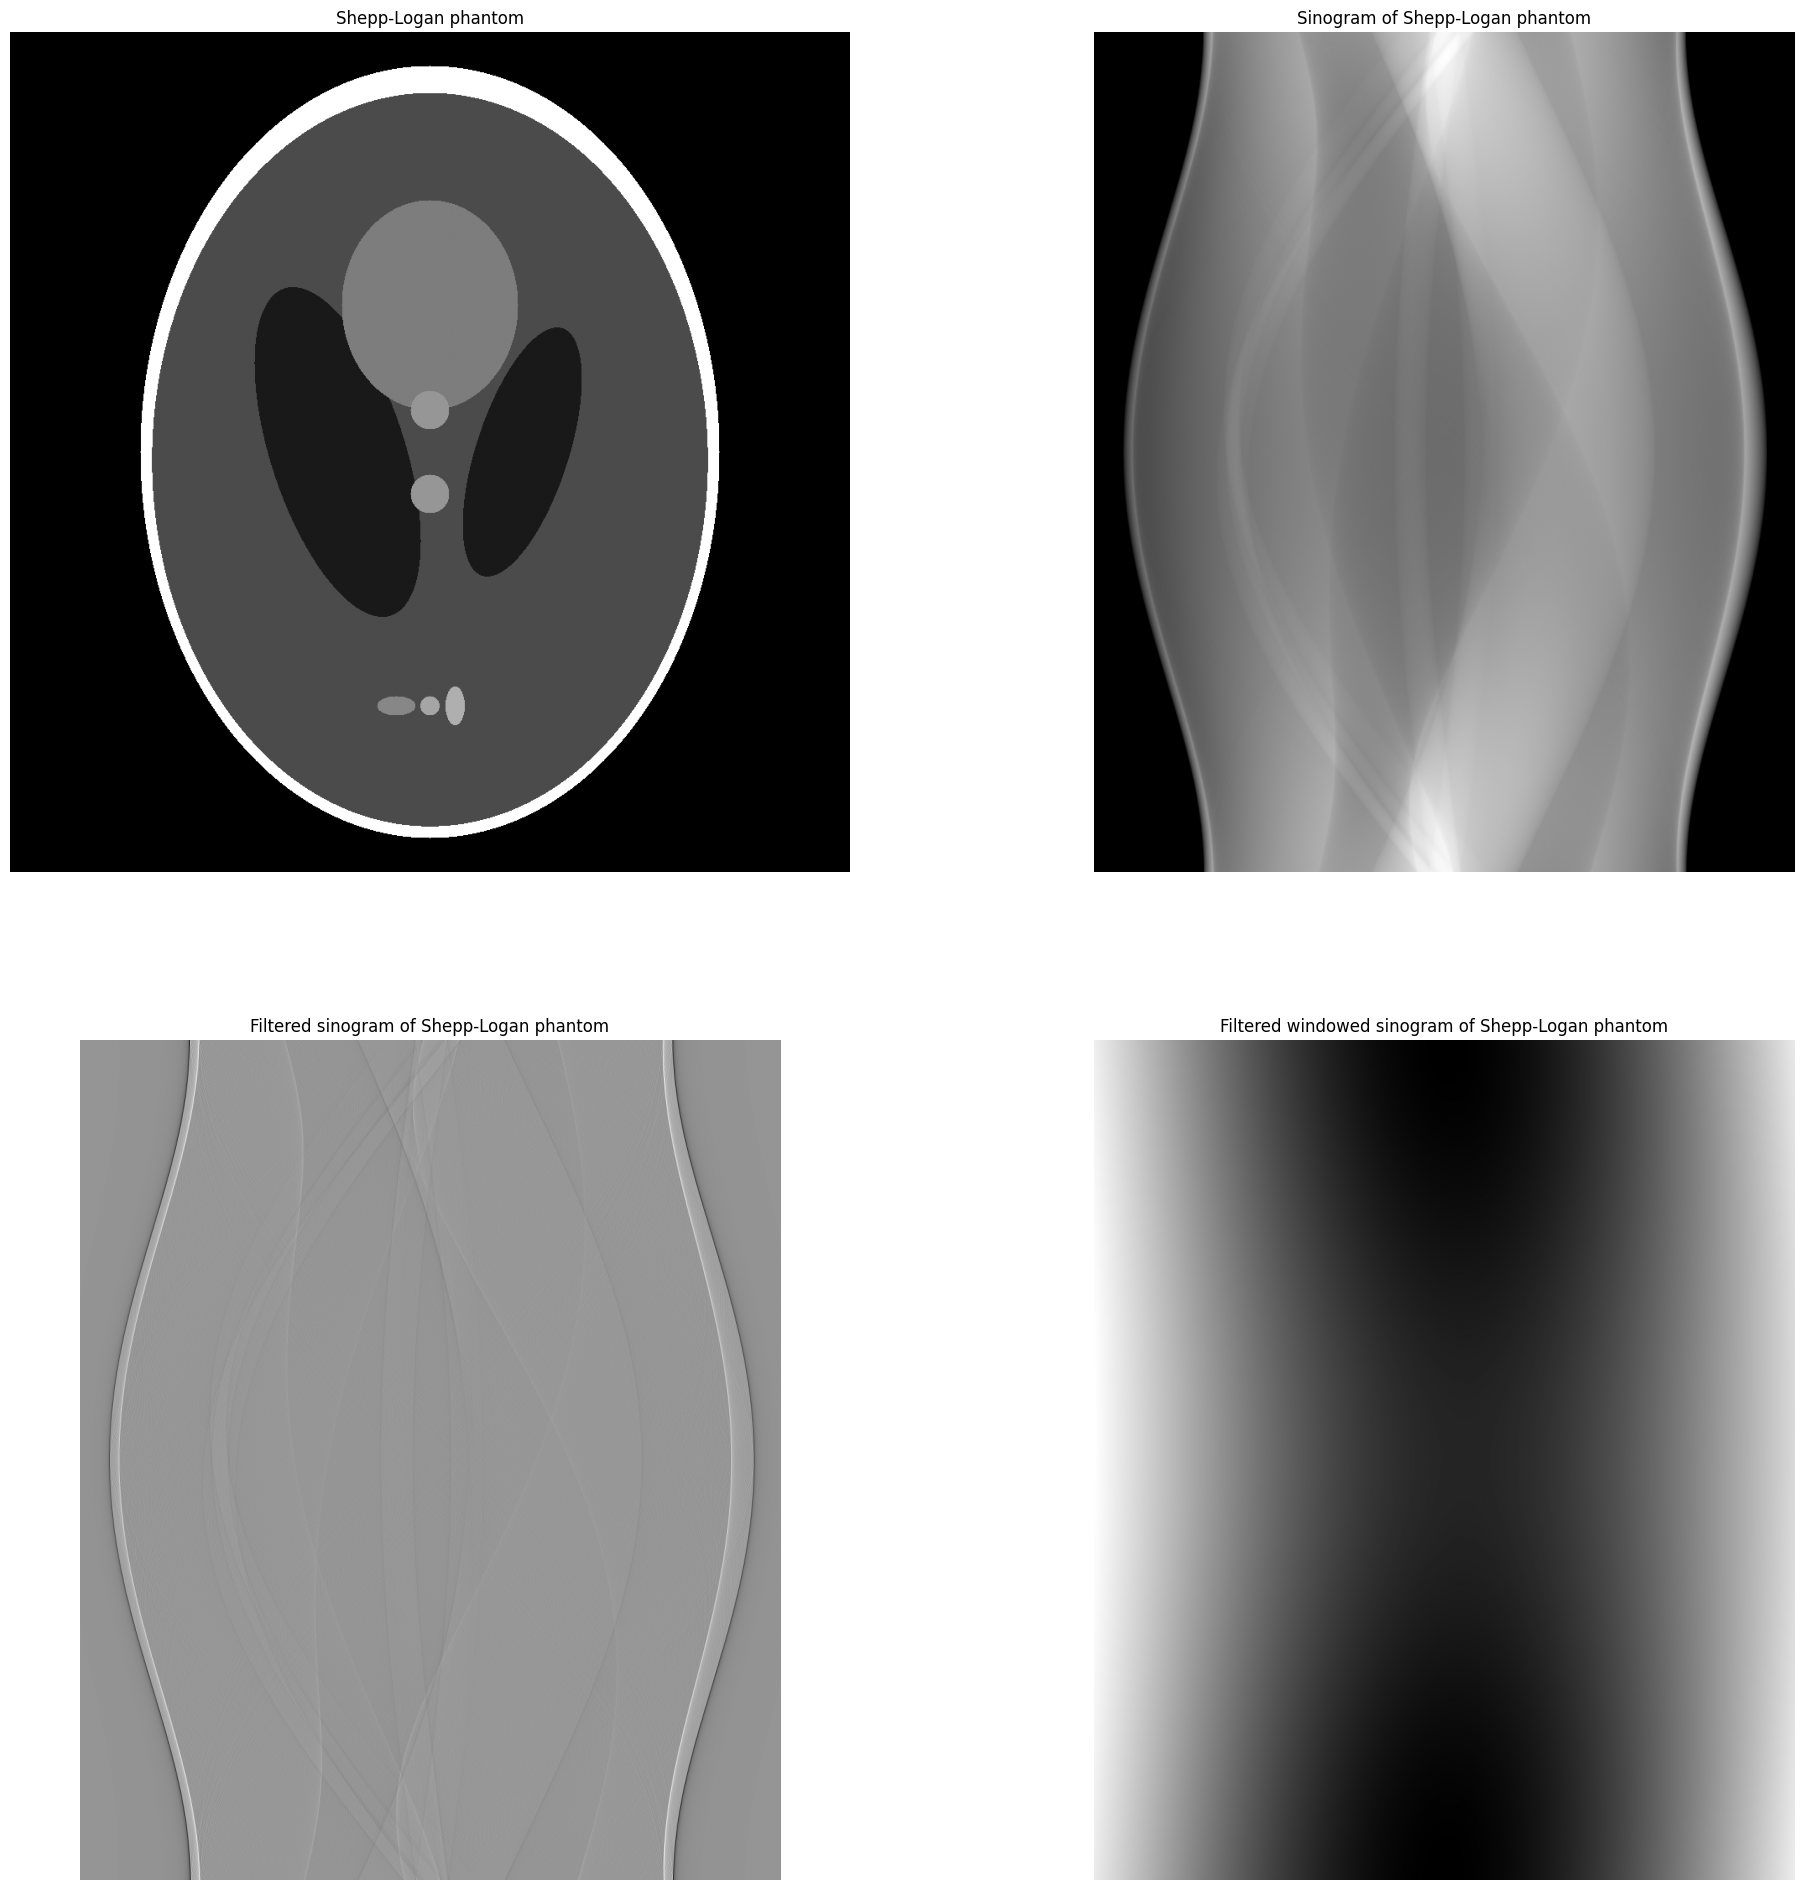

In [6]:
n_proj, n_det = sinogram.shape
n = np.arange(-n_det // 2, n_det // 2)
t = n * tau

filter = DiscreteWindowedRampFilter(tau)
h_t = filter(n)

n_kernel, = h_t.shape

n_fft = n_det + n_kernel - 1

H = np.fft.rfft(h_t, n_fft)
S = np.fft.rfft(sinogram, n_fft, axis=1)

filtered_sinogram = np.fft.irfft(S*H, n_fft, axis=1)

window_time = np.hamming(n_fft)
W = np.fft.rfft(window_time)

filtered_windowed_sinogram = np.fft.irfft(S*H*W, n_fft, axis=1)

start = (n_kernel - 1) // 2
end = start + n_det
filtered_sinogram = filtered_sinogram[:, start:end]
filtered_windowed_sinogram = filtered_windowed_sinogram[:, start:end]

fig, axs = plt.subplots(2,2, figsize=(24, 24))

axs[0,0].imshow(phantom, cmap="gray")
axs[0,0].set_title("Shepp-Logan phantom")
axs[0,0].axis("off")

axs[0,1].imshow(sinogram, cmap="gray")
axs[0,1].set_title("Sinogram of Shepp-Logan phantom")
axs[0,1].axis("off")

axs[1,0].imshow(filtered_sinogram, cmap="gray")
axs[1,0].set_title("Filtered sinogram of Shepp-Logan phantom")
axs[1,0].axis("off")

axs[1,1].imshow(filtered_windowed_sinogram, cmap="gray")
axs[1,1].set_title("Filtered windowed sinogram of Shepp-Logan phantom")
axs[1,1].axis("off")

In [7]:
from reconstruct import interpolate_projections

t_new, sinogram_new = interpolate_projections(t, sinogram, factor=10)

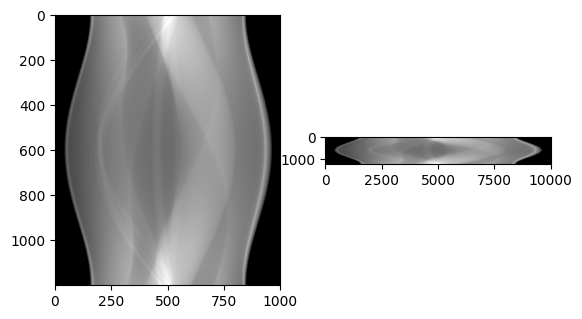

In [8]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(sinogram, cmap="gray")

axs[1].imshow(sinogram_new, cmap="gray")


Reconstructing with 1 projections


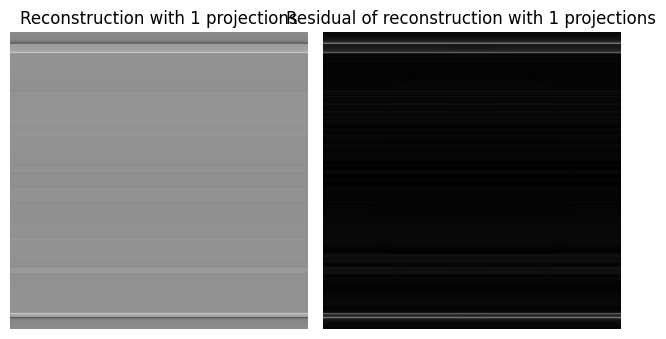

Reconstructing with 10 projections


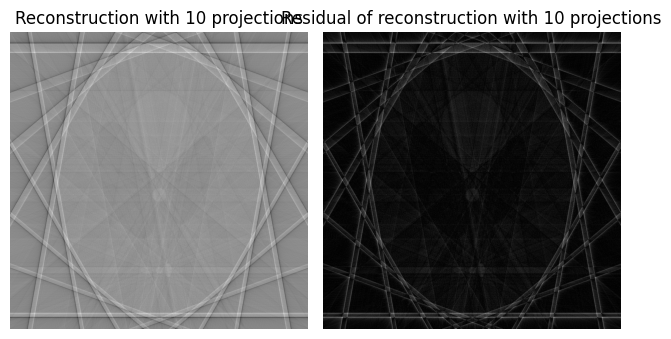

Reconstructing with 100 projections


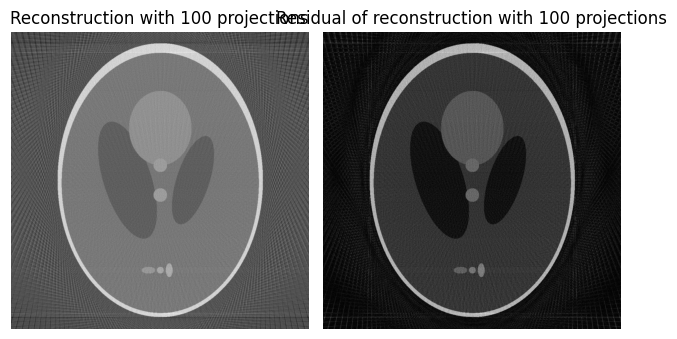

Reconstructing with 1000 projections


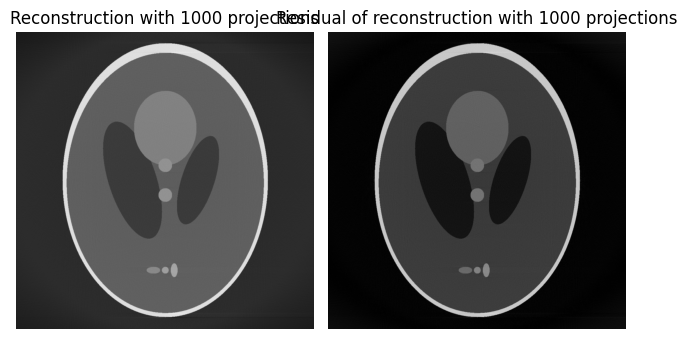

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shepp_logan import shepp_logan
from project import acquire_projections
from reconstruct import filter_projections, interpolate_projections, backproject, DiscreteWindowedRampFilter

N = 1001
K = [1,10,100,1000]
tau = 0.1
factor = 10

phantom = shepp_logan(N)

for k in K:
    print(f"Reconstructing with {k} projections")
    
    # Acquire projections
    P_theta = acquire_projections(phantom, n_projections=k, axis="x")
    
    # Filter projections
    Q_theta = filter_projections(P_theta, tau=tau)
    
    # Interpolate projections
    t = np.arange(-N // 2, N // 2) * tau
    t_new, Q_theta_interp = interpolate_projections(t, Q_theta, factor=factor)
    
    # Backproject to reconstruct the image
    recon = backproject(Q_theta_interp, N, t_new, tau)
    
    # Display the reconstruction
    plt.subplot(1,2,1)
    plt.imshow(recon, cmap="gray")
    plt.title(f"Reconstruction with {k} projections")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(np.abs(recon - phantom), cmap="gray")
    plt.title(f"Residual of reconstruction with {k} projections")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


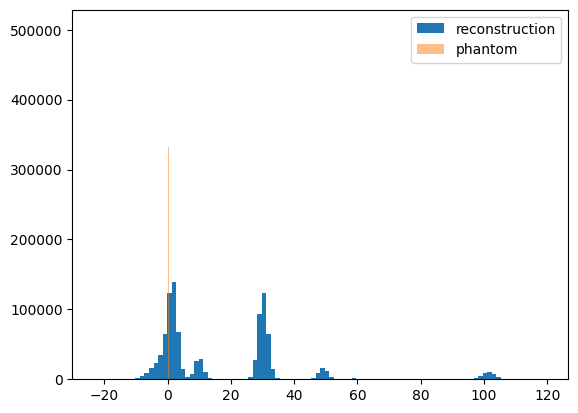

In [10]:
plt.hist(recon.flatten(), label="reconstruction", bins=100)
plt.hist(phantom.flatten(), label="phantom", bins=100, alpha=0.5)
plt.legend()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from shepp_logan import shepp_logan
from project import acquire_projections, acquire_projections_vectorised
from time import time
from reconstruct import filter_projections, interpolate_projections, backproject, DiscreteWindowedRampFilter

N = 1001
K = [1,10,100,1000]
tau = 0.1
factor = 10

phantom = shepp_logan(N)

start = time()
P_theta = acquire_projections(phantom, n_projections=1000, axis="x")
end = time()

print(f"Time taken for acquire_projections: {end - start:.2f} seconds")



Time taken for acquire_projections: 203.49 seconds


Time taken for acquire_projections_vectorised: 84.89 seconds


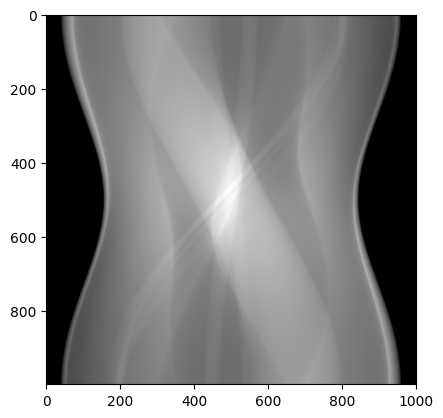

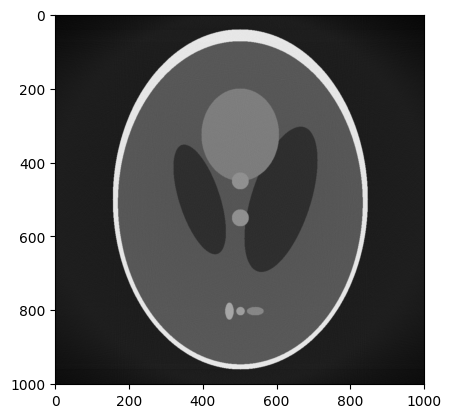

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shepp_logan import shepp_logan
from project import acquire_projections
from time import time
from reconstruct import filter_projections, interpolate_projections, backproject, DiscreteWindowedRampFilter

N = 1001
K = [1,10,100,1000]
tau = 0.1
factor = 10

phantom = shepp_logan(N)

start = time()
P_theta_vectorised = acquire_projections(phantom, n_projections=1000, axis="x", vectorised=True)
end = time()
print(f"Time taken for acquire_projections_vectorised: {end - start:.2f} seconds")

plt.imshow(P_theta_vectorised, cmap="gray")
plt.show()
# Filter projections
Q_theta = filter_projections(P_theta_vectorised, tau=tau)

# Interpolate projections
t = np.arange(-N // 2, N // 2) * tau
t_new, Q_theta_interp = interpolate_projections(t, Q_theta, factor=10)

# Backproject to reconstruct the image
recon = backproject(Q_theta_interp, N, t_new, tau)

plt.imshow(recon, cmap="gray")

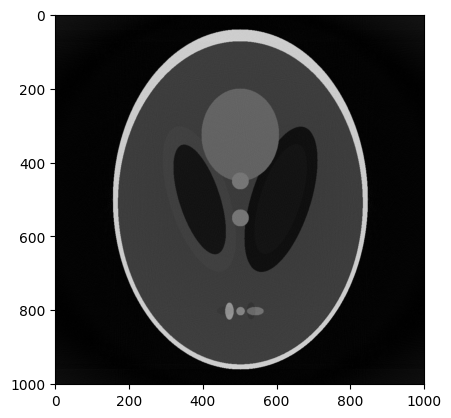

In [2]:
plt.imshow(np.abs(phantom - recon), cmap="gray")

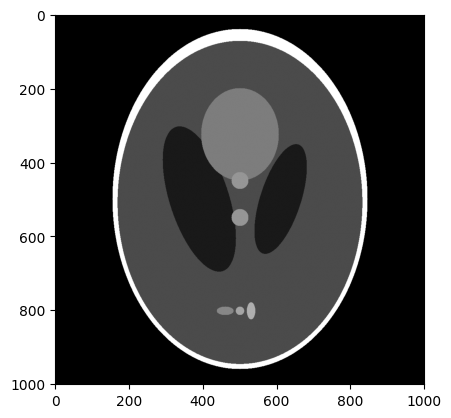

In [3]:
plt.imshow(phantom, cmap="gray")

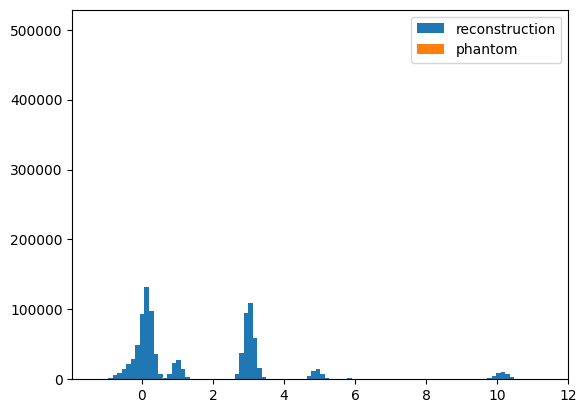

In [5]:
plt.hist(recon.flatten(), label="reconstruction", bins=100)
plt.hist(phantom.flatten(), label="phantom", bins=100)
plt.legend()

(array([5.03502e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 7.68790e+04,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 3.32025e+05,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 4.04410e+04, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 8.19000e+02, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 3.30100e+03, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 4.11000e+02,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 8.38

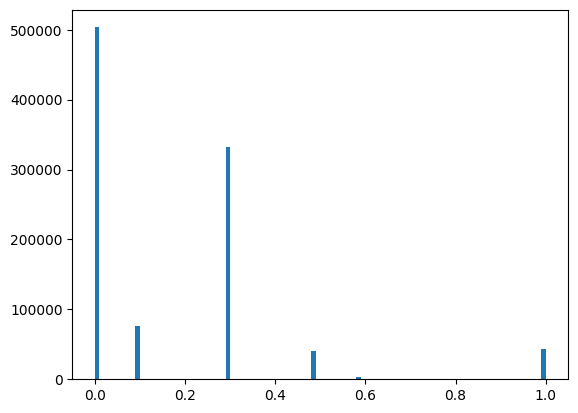

In [8]:
plt.hist(phantom.flatten(), label="phantom", bins=100)

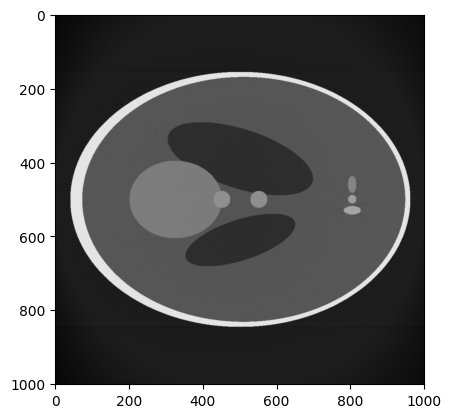

In [18]:
# Filter projections
Q_theta = filter_projections(P_theta_vectorised, tau=tau)

# Interpolate projections
t = np.arange(-N // 2, N // 2) * tau
t_new, Q_theta_interp = interpolate_projections(t, Q_theta, factor=10)

# Backproject to reconstruct the image
recon = backproject(Q_theta_interp, N, t_new, tau)

plt.imshow(recon, cmap="gray")

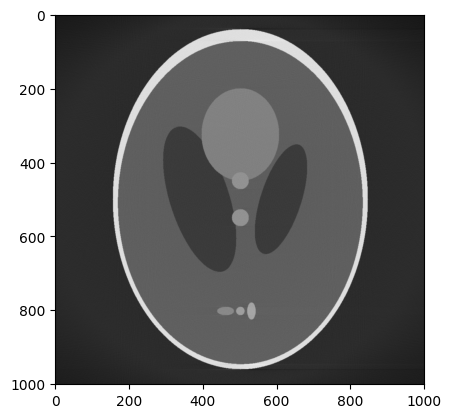

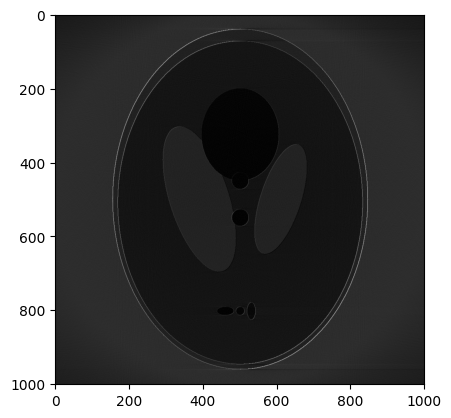

In [12]:
recon = (recon - recon.min()) / (recon.max() - recon.min())

plt.imshow(recon, cmap="gray")
plt.show()
plt.imshow(np.abs(recon - phantom), cmap="gray")
plt.show()

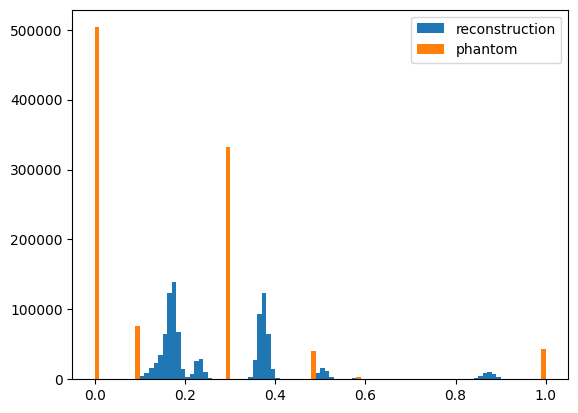

In [13]:
plt.hist(recon.flatten(), bins=100, label="reconstruction")
plt.hist(phantom.flatten(), bins=100, label="phantom")
plt.legend()
plt.show()

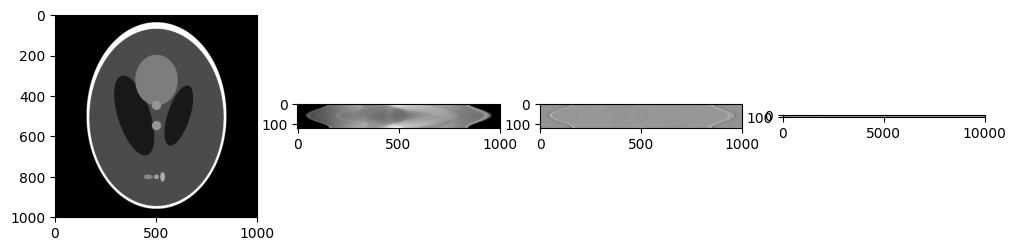

In [20]:
fig, axs = plt.subplots(1,4, figsize=(12, 48))

axs[0].imshow(phantom, cmap="gray")

axs[1].imshow(P_theta, cmap="gray")

axs[2].imshow(Q_theta, cmap="gray")

axs[3].imshow(Q_theta_interp, cmap="gray")


In [ ]:
import numpy as np



In [ ]:
import numpy as np

N = 256                      # phantom size
R_obj = N/2 * 0.9            # object fits in a 0.9·N radius
D_sd  = 1000.0               # source–detector distance in pixels
D_so  = 500.0                # source–object distance
fan_angle = 2*np.arcsin(R_obj / D_so)          # full fan angle covering object
N_det = 512                  # detector bins
delta_beta = fan_angle / N_det       # equi‑angular bin spacing
beta   = (np.arange(N_det) - (N_det-1)/2) * delta_beta     # detector angles wrt central ray

N_views = 360
theta = np.linspace(0, 2*np.pi, N_views, endpoint=False)   # view angles
sinogram = np.zeros((N_views, N_det), dtype=np.float32)  # (N_views, N_det) sinogram arra
C = (0, 0)                # centre of rotation in lab frame

# Source position in lab frame for every view
S = np.stack([ D_so * np.cos(theta),
               -D_so * np.sin(theta)], axis=1)  #  (N_views, 2) source positions in lab

# Unit vectors defining source frame at every view
e_r = np.stack([ -np.sin(theta),
                 -np.cos(theta)], axis=1)  # (N_views, 2) radial unit vectors from C to S
e_t = np.stack([  np.cos(theta),
                 -np.sin(theta)], axis=1)  # (N_views, 2) tangential unit vectors (right‑hand)

# Position of detector line at every view in lab frame
D_theta = C + (D_sd - D_so) * e_r  # (N_views, 2) detector line positions in lab frame

print("Source positions (S):", S.shape)
# print("Detector positions (D):", D.shape)
print("Detector line positions (D_theta):", D_theta.shape)
print("Radial unit vectors (e_r):", e_r.shape)
print("Tangential unit vectors (e_t):", e_t.shape)


print(S.shape)

for iv, th in enumerate(theta):
    # Source position in lab frame
    S = np.array([ D_so * np.cos(th),
                  -D_so * np.sin(th)])     # clockwise rotation
    
    # Unit vectors spanning detector at this view
    e_r = ( -np.sin(th), -np.cos(th) )     # radial from C to S
    e_t = (  np.cos(th), -np.sin(th) )     # tangential (right‑hand)

    # Detector line passes through D0 = C + (D_sd - D_so) * e_r
    D_theta = np.array(C) + (D_sd - D_so) * np.array(e_r)

    # Compute detector pixel centres
    D = D_theta[None,:] + D_sd * np.tan(beta)[:,None] * np.array(e_t)


def siddon(image, S, D):
    """
    image: 2‑D float32 array with voxel size = 1 px
    S, D : (2,) float64 source and detector endpoints in pixel coords
    Returns line integral ∑ f Δl.
    """
    nx, ny = image.shape

    # Shift so voxel (0,0) spans x∈[‑0.5,0.5], y∈[‑0.5,0.5]
    S = S + (nx/2, ny/2)
    D = D + (nx/2, ny/2)
    
    # Parametric intersections with vertical/horizontal voxel boundaries
    delta = D - S
    tx = (np.arange(nx+1) - S[0]) / delta[0] if delta[0] != 0 else np.array([-1*np.inf, np.inf])
    ty = (np.arange(ny+1) - S[1]) / delta[1] if delta[1] != 0 else np.array([-1*np.inf, np.inf])
    t   = np.unique(np.clip(np.concatenate((tx, ty)), 0, 1))
    if t[0] != 0:
        t = np.insert(t, 0, 0.0)
    if t[-1]!=1:
        t = np.append(t, 1.0)

    x_mid = (S[0] + S[0] + delta[0]* (t[:-1] + t[1:])/2).astype(int)
    y_mid = (S[1] + S[1] + delta[1]* (t[:-1] + t[1:])/2).astype(int)
    valid = (x_mid>=0)&(x_mid<nx)&(y_mid>=0)&(y_mid<ny)
    seg   = np.sqrt((delta[0]*(t[1:]-t[:-1]))**2 + (delta[1]*(t[1:]-t[:-1]))**2)
    return np.sum(image[x_mid[valid], y_mid[valid]] * seg[valid])

phantom = shepp_logan(N)

proj = np.zeros(N_det, dtype=np.float32)
for idet, (Sd, Dd) in enumerate(zip(np.repeat(S[None,:], N_det, 0), D)):
    proj[idet] = siddon(phantom, Sd, Dd)
sinogram[iv,:] = proj

plt.imshow(phantom, cmap="gray")
plt.title("Shepp-Logan phantom")
plt.axis("off") 
plt.show()

plt.imshow(sinogram, cmap="gray")
plt.title("Sinogram of Shepp-Logan phantom")
plt.axis("off")
plt.show()


ValueError: operands could not be broadcast together with shapes (1,512,1) (1,360,2) 

array([-0.23203464, -0.23112648, -0.23021832, -0.22931017, -0.22840201,
       -0.22749385, -0.22658569, -0.22567753, -0.22476937, -0.22386121,
       -0.22295305, -0.22204489, -0.22113673, -0.22022857, -0.21932042,
       -0.21841226, -0.2175041 , -0.21659594, -0.21568778, -0.21477962,
       -0.21387146, -0.2129633 , -0.21205514, -0.21114698, -0.21023882,
       -0.20933067, -0.20842251, -0.20751435, -0.20660619, -0.20569803,
       -0.20478987, -0.20388171, -0.20297355, -0.20206539, -0.20115723,
       -0.20024908, -0.19934092, -0.19843276, -0.1975246 , -0.19661644,
       -0.19570828, -0.19480012, -0.19389196, -0.1929838 , -0.19207564,
       -0.19116748, -0.19025933, -0.18935117, -0.18844301, -0.18753485,
       -0.18662669, -0.18571853, -0.18481037, -0.18390221, -0.18299405,
       -0.18208589, -0.18117773, -0.18026958, -0.17936142, -0.17845326,
       -0.1775451 , -0.17663694, -0.17572878, -0.17482062, -0.17391246,
       -0.1730043 , -0.17209614, -0.17118798, -0.17027983, -0.16

In [16]:
theta

array([0.        , 0.01745329, 0.03490659, 0.05235988, 0.06981317,
       0.08726646, 0.10471976, 0.12217305, 0.13962634, 0.15707963,
       0.17453293, 0.19198622, 0.20943951, 0.2268928 , 0.2443461 ,
       0.26179939, 0.27925268, 0.29670597, 0.31415927, 0.33161256,
       0.34906585, 0.36651914, 0.38397244, 0.40142573, 0.41887902,
       0.43633231, 0.45378561, 0.4712389 , 0.48869219, 0.50614548,
       0.52359878, 0.54105207, 0.55850536, 0.57595865, 0.59341195,
       0.61086524, 0.62831853, 0.64577182, 0.66322512, 0.68067841,
       0.6981317 , 0.71558499, 0.73303829, 0.75049158, 0.76794487,
       0.78539816, 0.80285146, 0.82030475, 0.83775804, 0.85521133,
       0.87266463, 0.89011792, 0.90757121, 0.9250245 , 0.9424778 ,
       0.95993109, 0.97738438, 0.99483767, 1.01229097, 1.02974426,
       1.04719755, 1.06465084, 1.08210414, 1.09955743, 1.11701072,
       1.13446401, 1.15191731, 1.1693706 , 1.18682389, 1.20427718,
       1.22173048, 1.23918377, 1.25663706, 1.27409035, 1.29154